In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

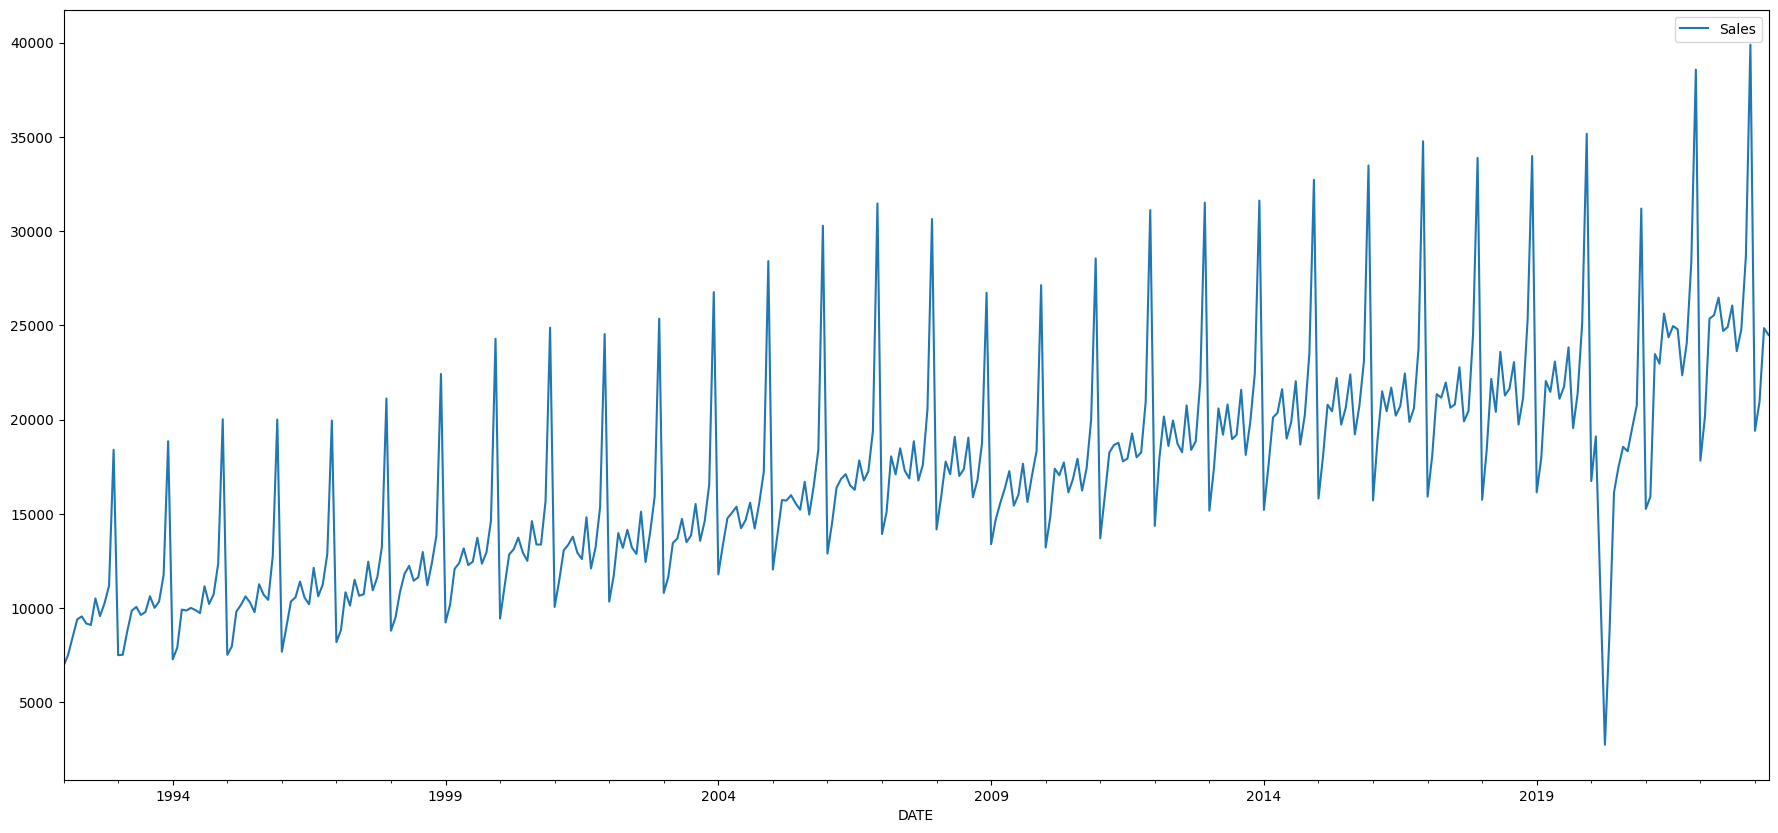

In [6]:
df.plot(figsize=(22,10))

## Répartition Entraînement / Test

> Indented block

In [7]:
len(df)

376

Les données sont mensuelles, prévoyons un an et demi dans le futur.

In [8]:
len(df)-18

358

In [9]:
test_size = 18

In [10]:
test_ind = len(df)-test_size

In [11]:
test_ind

358

In [12]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [13]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2021-06-01,24364
2021-07-01,24961
2021-08-01,24789


In [13]:
test

,Sales
DATE,
2021-11-01,28340
2021-12-01,38564
2022-01-01,17817
2022-02-01,20152
2022-03-01,25347
2022-04-01,25539
2022-05-01,26470
2022-06-01,24701
2022-07-01,24904


## Mise à l'échelle des données

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [17]:
scaler_train = scaler.transform(train)
scaler_test = scaler.transform(test)

## Générateur de séries temporelles

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
# Redéfinissons pour obtenir 12 mois en arrière et prédisons le mois suivant
length = 12
generator = TimeseriesGenerator(scaler_train, scaler_train, length=length, batch_size=1)

In [20]:
# À quoi ressemble le premier batch ?
X,y = generator[0]

In [21]:
print(f"Compte tenu du tableau suivant : \n {X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
 [0.12916564 0.14724759 0.1765922  0.20516539 0.21000987 0.1984078
 0.19597013 0.23947791 0.21047272 0.23148605 0.26027524 0.48268946]
Cela prédit ce y : 
 [[0.14656875]]


## Création du Modèle

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [23]:
# Nous n'utilisons qu'une seule feature dans notre série temporelle
n_features = 1

In [24]:
# définir le modèle
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping et création d'un Générateur de Validation

REMARQUE : la taille de l'ensemble de données scaled_test DOIT être supérieure à la longueur choisie pour vos batchs. Regardez la vidéo pour plus d'informations à ce sujet.

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [28]:
validation_generator = TimeseriesGenerator(scaler_test,scaler_test,length=length,batch_size=1)

In [29]:
model.fit_generator(generator,epochs=20, validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2944\1459820252.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20, validation_data=validation_generator,callbacks=[early_stop])


346/346 [==============================] - 3s 6ms/step - loss: 0.0253 - val_loss: 0.0737
Epoch 2/20
346/346 [==============================] - 2s 6ms/step - loss: 0.0171 - val_loss: 0.0414
Epoch 3/20
346/346 [==============================] - 2s 6ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 4/20
346/346 [==============================] - 2s 6ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 5/20
346/346 [==============================] - 2s 6ms/step - loss: 0.0081 - val_loss: 0.0267
Epoch 6/20
346/346 [==============================] - 2s 7ms/step - loss: 0.0066 - val_loss: 0.0026
Epoch 7/20
346/346 [==============================] - 2s 6ms/step - loss: 0.0054 - val_loss: 1.8239e-04
Epoch 8/20
346/346 [==============================] - 2s 6ms/step - loss: 0.0050 - val_loss: 0.0069
Epoch 9/20
346/346 [==============================] - 2s 6ms/step - loss: 0.0050 - val_loss: 0.0057


In [30]:
losses = pd.DataFrame(model.history.history)

<Axes: >

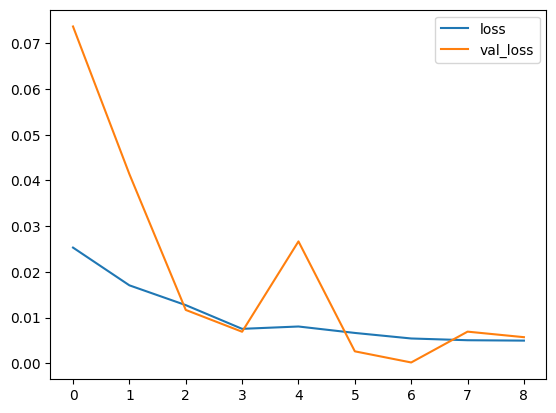

In [31]:
losses.plot()

## Évaluation sur les données de test

In [32]:
first_eval_batch = scaler_train[-length:]

In [33]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [34]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 162ms/step


array([[0.6585827]], dtype=float32)

In [35]:
scaler_test[0]

array([0.78955813])

Mettons maintenant cette logique dans une boucle for pour prédire l'avenir pour toute la gamme de test.

----

**NOTE : Soyez attentif ici aux sorties et aux dimensions. Ajoutez vos propres commandes print() pour voir ce qui se passe vraiment !**

In [36]:
test_predictions = []

first_eval_batch = scaler_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 15ms/step


## Transformations inverses et Comparaison

In [37]:
test_predictions

[array([0.6585827], dtype=float32),
 array([0.9417259], dtype=float32),
 array([0.52982044], dtype=float32),
 array([0.54287404], dtype=float32),
 array([0.6697814], dtype=float32),
 array([0.6678502], dtype=float32),
 array([0.747686], dtype=float32),
 array([0.7240081], dtype=float32),
 array([0.74700433], dtype=float32),
 array([0.74848795], dtype=float32),
 array([0.6825593], dtype=float32),
 array([0.7273532], dtype=float32),
 array([0.7502675], dtype=float32),
 array([1.0400776], dtype=float32),
 array([0.62288773], dtype=float32),
 array([0.6379226], dtype=float32),
 array([0.7260726], dtype=float32),
 array([0.73162824], dtype=float32)]

In [38]:
scaler_test

array([[0.78955813],
       [1.10503579],
       [0.46485436],
       [0.53690447],
       [0.69720439],
       [0.70312886],
       [0.73185633],
       [0.67727104],
       [0.68353493],
       [0.71886571],
       [0.64419279],
       [0.67992471],
       [0.79896939],
       [1.14573562],
       [0.5138546 ],
       [0.56112688],
       [0.68183782],
       [0.67060602]])

In [39]:
true_prediction = scaler.inverse_transform(test_predictions)

In [40]:
test['Predictions'] = true_prediction

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2944\1596403840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_prediction


In [41]:
test

,Sales,Predictions
DATE,,
2021-11-01,28340,24095.347733
2021-12-01,38564,33271.453282
2022-01-01,17817,19922.420891
2022-02-01,20152,20345.461831
2022-03-01,25347,24458.275185
2022-04-01,25539,24395.689164
2022-05-01,26470,26983.008811
2022-06-01,24701,26215.653965
2022-07-01,24904,26960.916332


<Axes: xlabel='DATE'>

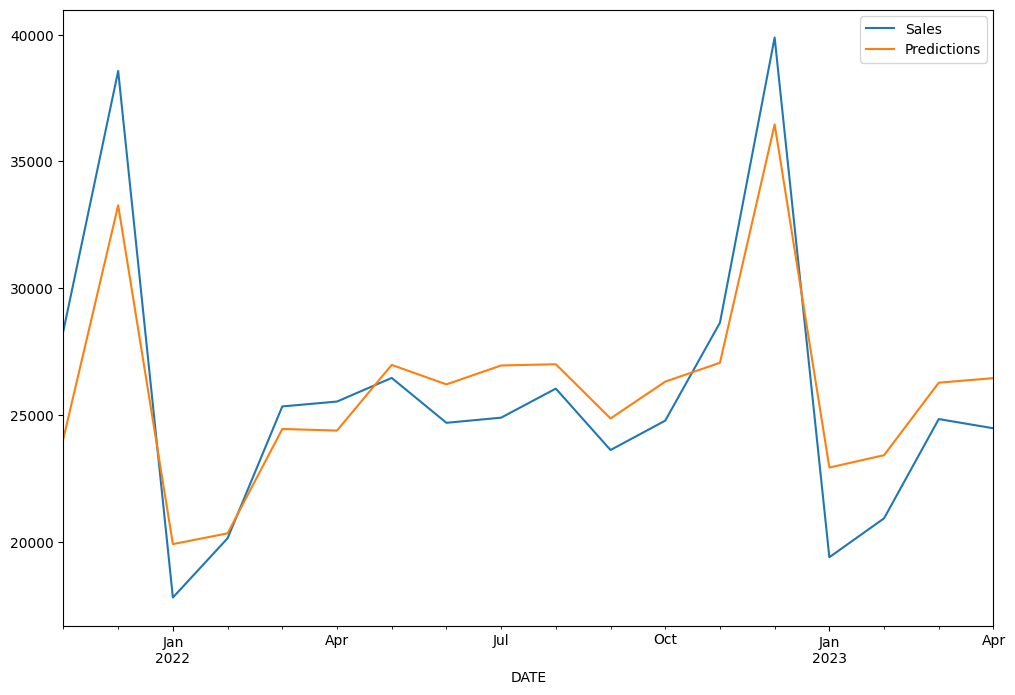

In [42]:
test.plot(figsize=(12,8))

# Pour les prediction futurw

In [43]:
full_scaler = MinMaxScaler()

In [44]:
scaler_full_data = full_scaler.fit_transform(df)

In [45]:
length = 12
generator = TimeseriesGenerator(scaler_full_data,scaler_full_data,length=length,batch_size=1)

In [47]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(generator,epochs=9)

Epoch 1/9
364/364 [==============================] - 3s 5ms/step - loss: 0.0188
Epoch 2/9
364/364 [==============================] - 2s 5ms/step - loss: 0.0138
Epoch 3/9
364/364 [==============================] - 2s 6ms/step - loss: 0.0100
Epoch 4/9
364/364 [==============================] - 2s 5ms/step - loss: 0.0065
Epoch 5/9
364/364 [==============================] - 2s 5ms/step - loss: 0.0050
Epoch 6/9
364/364 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 7/9
364/364 [==============================] - 1s 4ms/step - loss: 0.0058
Epoch 8/9
364/364 [==============================] - 2s 4ms/step - loss: 0.0044
Epoch 9/9
364/364 [==============================] - 1s 3ms/step - loss: 0.0045


In [48]:
forecast = []

periode = 12

first_eval_batch = scaler_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periode):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    forecast.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [49]:
forecast = full_scaler.inverse_transform(forecast)

In [50]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2022-12-01,39883
2023-01-01,19405
2023-02-01,20937


In [51]:
forecast

array([[24126.20477027],
       [32542.41510028],
       [19254.04599261],
       [19849.51979458],
       [24075.74647796],
       [23761.16727668],
       [26179.73709142],
       [25177.09570014],
       [25796.29036605],
       [25695.58624673],
       [23519.76023471],
       [24862.99897212]])

In [52]:
forecast_index = pd.date_range(start='2023-05-01',periods=periode,freq='MS')

In [53]:
forecast_index

DatetimeIndex(['2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [54]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

In [55]:
forecast_df

,Forecast
2023-05-01,24126.204770
2023-06-01,32542.415100
2023-07-01,19254.045993
2023-08-01,19849.519795
2023-09-01,24075.746478
2023-10-01,23761.167277
2023-11-01,26179.737091
2023-12-01,25177.095700
2024-01-01,25796.290366
2024-02-01,25695.586247


<Axes: >

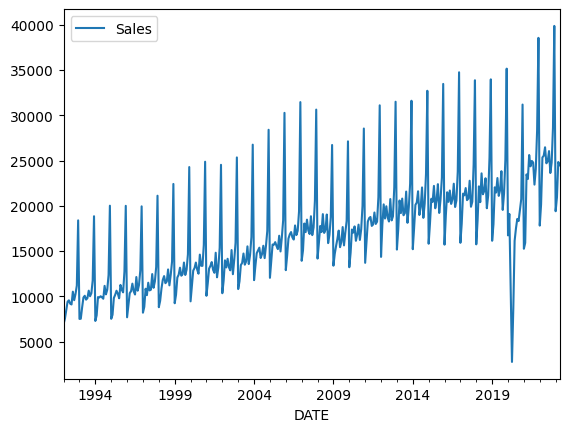

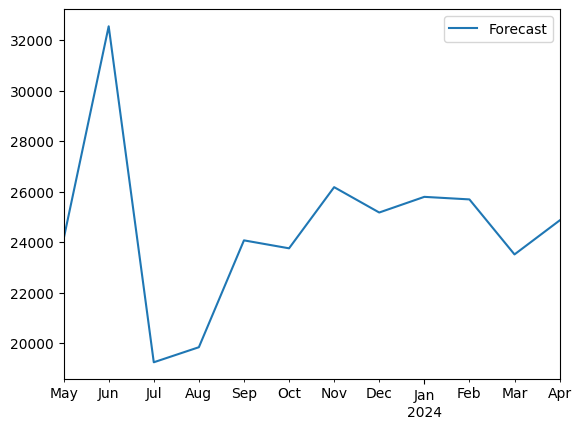

In [56]:
df.plot()
forecast_df.plot()

(576.0, 652.0)

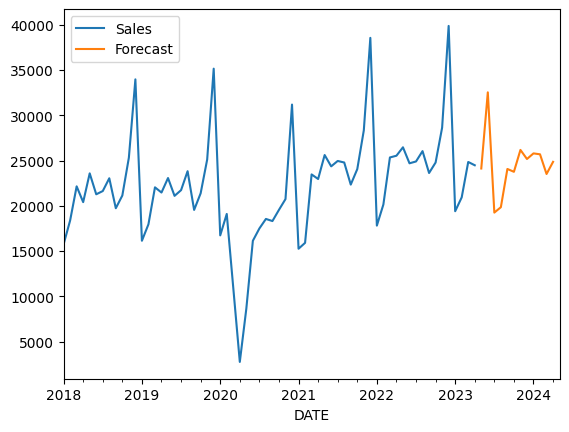

In [57]:
ax=df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2024-05-01')